# Optimizing non-maximum supression
* Must choose the radius and the cutoff values
* Post processing to improve the classification

In [2]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*

import pickle
from keras.models import load_model
import os
import numpy as np
import pandas as pd
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
test_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/valid'
heat_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/heat_conv_incp3_192/valid'
cutoff=.95
radius = 5

acc=test_heat_preds(test_folder=test_folder, heat_folder=heat_folder, radius=radius, cutoff=cutoff, output_class=True, stride=2)

TP = len(acc["all_matched_pts"])/float(acc["total_nuclei"])
FPT = (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"])
print TP
print FPT

0.869105900541
0.46611698016


## Selecting cutoff and radius
* Too small radius will result in multiple positive identifications per nuclei
* Too large a radius will cause close nuclei to be supressed to 0
* In the ideal case we would have equal sized cells, and so could set the radius to be this.
* Not clear what the best accuracy metric is, so will use something like ROC

### Look at the distribution of distances between a cell and its nearest neighbour to get an idea how wide the cells are:

In [17]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
import numpy as np
import glob
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import pprint
% matplotlib inline

weird_list=[]

train_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/train'
all_files=glob.glob(os.path.join(train_dir, '*'))
print 'len(all_files)', len(all_files)
all_xml = [loc for loc in all_files if 'key' in loc]
print 'len(all_xml)', len(all_xml)
all_min_dists = []
for xml_loc in all_xml:
    all_points = get_points_xml(xml_loc)
    point_list = all_points[:, 0:2]
    for index, point in enumerate(point_list):
        temp_point_list = np.delete(point_list, (index), axis=0) # don't match the point with itself
        dists = np.sqrt(np.sum((temp_point_list - point) ** 2, axis=1))
        min_ind = np.argmin(dists) 
        all_min_dists.append(dists[min_ind])
        if dists[min_ind]<4:
            weird_list.append(xml_loc) #.rsplit('/', 1)[-1])

print Counter(weird_list)
weird_list = list(set(weird_list))
print len(weird_list)

len(all_files) 178
len(all_xml) 89
Counter({'/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/train/62_Region_3_key.xml': 4})
1


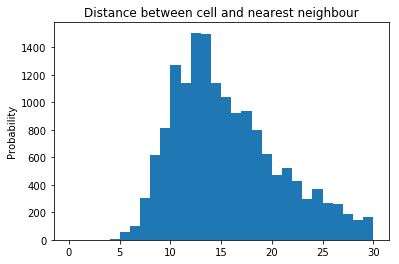

In [18]:
plt.hist(all_min_dists, bins=30, range=[0, 30], normed=False)
plt.title('Distance between cell and nearest neighbour')
plt.ylabel('Probability');

* There were under 5 distances, but these were are errors and are removed. They are identified in the exploring data notebook. 
* Seems the minumum cell distance is about 7-8. 
* This can be overestimated slighly to help reduce false positives, because the classifier predicts an area larger than one pixel as positive.

### Perfomance trade off of changing the radius
* Plot it in a way similair to ROC, to see how changing the cutoff increases the number of true nuclei located, but also increases the number of false positives
* False positive rate will always be high because not all cells in the data are labeled
* This is using the set of heatmaps that currently seem the best, as this is the only sensible option.

In [26]:
test_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/valid'
heat_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/heat_conv_incp3_192/valid'
abs_error_means=[]
settings=[]
results = np.zeros((11, 4, 2))
for col, radius in enumerate(range(4, 8)):
    print radius
    for row, cutoff in enumerate([.3, .5, .7, .8, .9, .95, .97, .98, .99, .999, .9999]):
        acc = test_heat_preds(test_folder=test_folder, heat_folder=heat_folder, radius=radius, cutoff=cutoff, output_class=True, stride = 2)
        TP = len(acc["all_matched_pts"])/float(acc["total_nuclei"])
        FPT = (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"])
        results[row, col, 0] = TP
        results[row, col, 1] = FPT
        

4
5
6
7


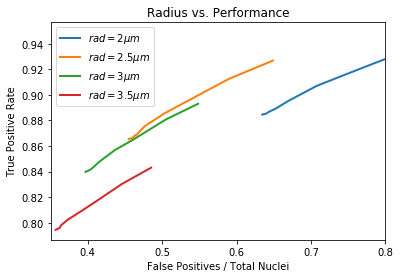

In [42]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc


plt.plot(results[:,0,1], results[:,0,0], linewidth=2.0, label=r'$rad = 2 \mu m$')
plt.plot(results[:,1,1], results[:,1,0], linewidth=2.0, label=r'$rad = 2.5 \mu m$')
plt.plot(results[:,2,1], results[:,2,0], linewidth=2.0, label=r'$rad = 3 \mu m$')
plt.plot(results[:,3,1], results[:,3,0], linewidth=2.0, label=r'$rad = 3.5 \mu m$')
plt.legend()
axes = plt.gca()
axes.set_xlim([.35, .8])
# axes.set_ylim([.7, 1])
axes.set_xlabel("False Positives / Total Nuclei")
axes.set_ylabel("True Positive Rate")

plt.title('Radius vs. Performance') 

plt.show()

## Radius dependent on class
* We know that different cell types have different sizes 
* Adjust the non-max supression based on this 

#### First check the magnitude of the differences:

In [4]:
train_dir = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/train'

all_files=glob.glob(os.path.join(train_dir, '*'))
print 'len(all_files)', len(all_files)
all_xml = [loc for loc in all_files if 'key' in loc]
print 'len(all_xml)', len(all_xml)
lymphocyte_dists = []
normal_dists = []
malignant_dists = []

for xml_loc in all_xml:
    all_points = get_points_xml(xml_loc)
    point_list = all_points[:, 0:2]
    for index, point in enumerate(point_list):
        temp_point_list = np.delete(point_list, (index), axis=0) # don't match the point with itself
        dists = np.sqrt(np.sum((temp_point_list - point) ** 2, axis=1))
        min_ind = np.argmin(dists) 
        if (all_points[index, 2] == 1) :
            lymphocyte_dists.append(dists[min_ind])
        elif (all_points[index, 2] == 2):
            normal_dists.append(dists[min_ind])
        elif (all_points[index, 2] == 3):
            malignant_dists.append(dists[min_ind])
        else:
            print 'error'

print 'len(lymphocyte_dists)', len(lymphocyte_dists)
print 'len(normal_dists)', len(normal_dists)
print 'len(malignant_dists)', len(malignant_dists)

len(all_files) 178
len(all_xml) 89
len(lymphocyte_dists) 1753
len(normal_dists) 6910
len(malignant_dists) 7875


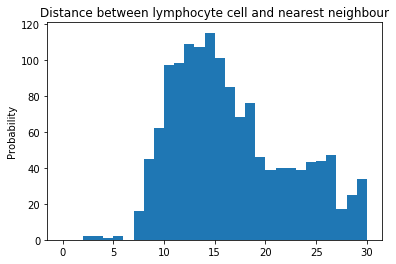

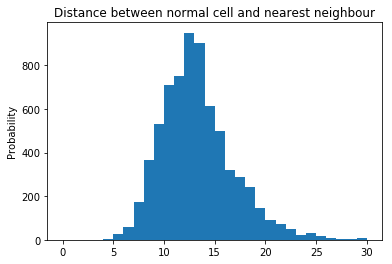

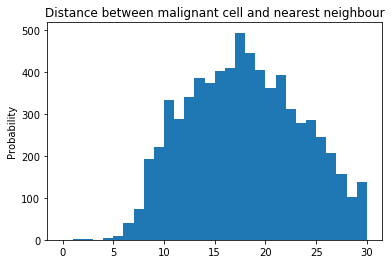

In [5]:
plt.hist(lymphocyte_dists, bins=30, range=[0, 30], normed=False)
plt.title('Distance between lymphocyte cell and nearest neighbour')
plt.ylabel('Probability');
plt.show()

plt.hist(normal_dists, bins=30, range=[0, 30], normed=False)
plt.title('Distance between normal cell and nearest neighbour')
plt.ylabel('Probability');
plt.show()

plt.hist(malignant_dists, bins=30, range=[0, 30], normed=False)
plt.title('Distance between malignant cell and nearest neighbour')
plt.ylabel('Probability');
plt.show()

In [19]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*
from heat_models import*

test_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/full_slides/valid'
heat_folder = '/Users/rb/Documents/waterloo/projects/cancer_hist/final/heat_conv_incp3_192/valid'
abs_error_means=[]
settings=[]
results = np.zeros((12, 5, 2)) 
radius_list = [(5,5,5), (5, 5, 6), (4, 5, 6), (5, 6, 7), (5, 5, 7)]
for col, radius in enumerate(radius_list):
    print radius
    for row, cutoff in enumerate([.2, .5, .7, .8, .9, .95, .97, .98, .99, .999, .9999, .99999]):
        acc = test_heat_preds(test_folder=test_folder, heat_folder=heat_folder, radius=radius, cutoff=cutoff, output_class=True, stride=2)
        TP = len(acc["all_matched_pts"])/float(acc["total_nuclei"])
        FPT = (float(acc["num_predicted"])-len(acc["all_matched_pts"]))/float(acc["total_nuclei"])
        results[row, col, 0] = TP
        results[row, col, 1] = FPT

(5, 5, 5)
(5, 5, 6)
(4, 5, 6)
(5, 6, 7)
(5, 5, 7)


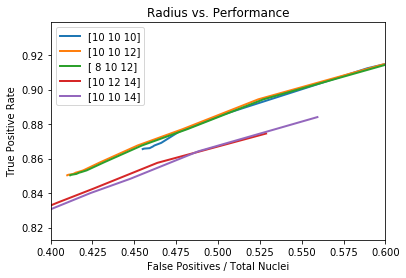

In [25]:
% matplotlib inline
import matplotlib.pyplot as plt

for i in range(len(radius_list)):
    plt.plot(results[:,i,1], results[:,i,0], linewidth=2.0, label=np.multiply(2, radius_list[i]))
plt.legend()
axes = plt.gca()
axes.set_xlabel("False Positives / Total Nuclei")
axes.set_ylabel("True Positive Rate")
axes.set_xlim([.4, .6])
# axes.set_ylim([.7, 1])

plt.title('Radius vs. Performance')

plt.show()

#### Making the radius dependent on the nuclei classification is ineffective